In [18]:

import json
import os
import sys

import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf
import open3d as o3d
import open_clip
import plyfile
from scipy.spatial import cKDTree
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import BallTree
import torch
import torchmetrics as tm
from hydra import initialize, compose

from hovsg.labels.label_constants import (
    SCANNET_COLOR_MAP_20, 
    SCANNET_LABELS_20, 
    TRUCKSCENES_LABELS,
    TRUCKSCENES_COLORMAP
)

from hovsg.utils.eval_utils import (
    load_feature_map,
    knn_interpolation,
    read_ply_and_assign_colors,
    read_semantic_classes,
    sim_2_label,
    read_semantic_classes_replica,
    text_prompt,
    read_ply_and_assign_colors_replica
)
from hovsg.utils.metric import (
    frequency_weighted_iou,
    mean_iou,
    mean_accuracy,
    pixel_accuracy,
    per_class_iou,
)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "1", "0,1", etc.


# Manually initialize Hydra and load the config
config_path = "../../config"
config_name = "eval_sem_seg"

# Hydra context for manual loading
with initialize(version_base=None, config_path=config_path):
    params = compose(config_name=config_name)


In [19]:
# load CLIP model
if params.models.clip.type == "ViT-L/14@336px":
    clip_model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-L-14",
        pretrained=str(params.models.clip.checkpoint),
        device=params.main.device,
    )
    clip_feat_dim = 768
elif params.models.clip.type == "ViT-H-14":
    clip_model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-H-14",
        pretrained=str(params.models.clip.checkpoint),
        device=params.main.device,
    )
    clip_feat_dim = 1024
clip_model.eval()


# Load Feature Map
masked_pcd, mask_feats = load_feature_map(params.main.feature_map_path)

# read semantic classes
scene_name = params.main.scene_name
if params.main.dataset == "scannet":
    SCANNET_LABELS_20_list = list(SCANNET_LABELS_20)
    labels = SCANNET_LABELS_20_list
    labels_id = list(SCANNET_COLOR_MAP_20.keys())
elif params.main.dataset == "replica":
    semantic_info_path = os.path.join(
        params.main.replica_dataset_gt_path, scene_name, "habitat", "info_semantic.json"
    )
    class_id_name = read_semantic_classes_replica(semantic_info_path, crete_color_map=True)
    # add background class with id len(class_id_name)+1
    class_id_name[0] = "background"
    labels = list(class_id_name.values())
    labels_id = list(class_id_name.keys())
elif params.main.dataset == "truckscenes":
    TRUCKSCENES_LABELS_list = list(TRUCKSCENES_LABELS)
    labels = TRUCKSCENES_LABELS_list
    labels_id = list(TRUCKSCENES_COLORMAP.keys())

sim = text_prompt(clip_model, clip_feat_dim, mask_feats, labels, templates=True)
labels = sim_2_label(sim, labels_id)
labels = np.array(labels)

full pcd feats loaded from disk with shape (26, 1024)
number of masked pcds loaded from disk 26
number of mask_feats loaded from disk 26
label_indices:  [ 4  4 10  4 11 10 11 10 10 10  4 11 11 10 11  4  4 12 10 12  4  4  4  4
  4 10]


/tmp/ipykernel_3273178/4085606095.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/tmp/ipykernel_3273178/4085606095.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


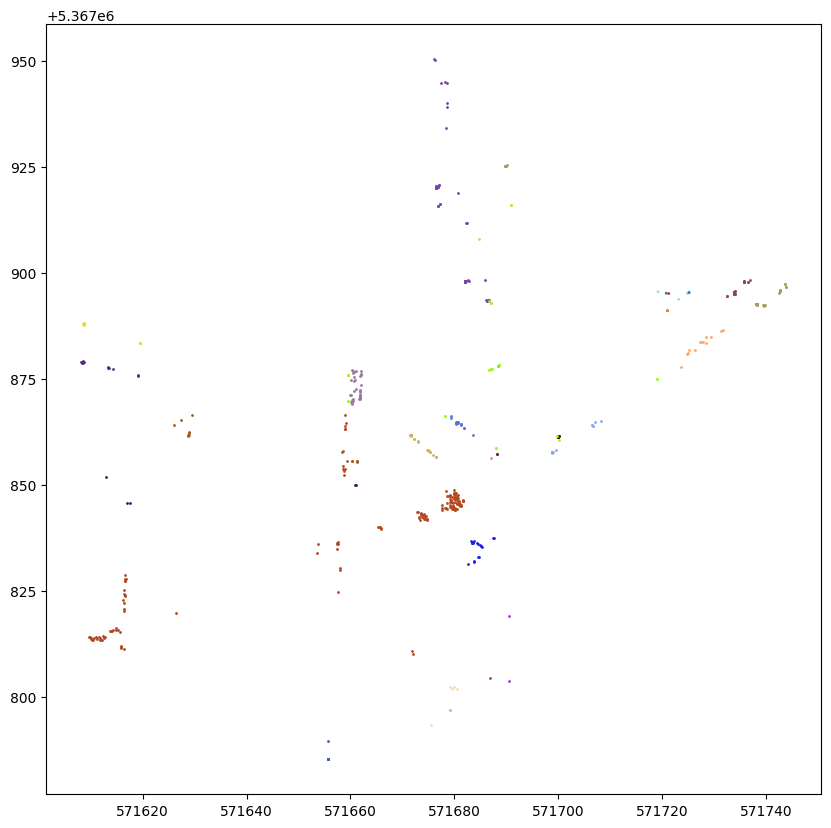

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for pcd in masked_pcd:
    plt.scatter(
        np.array(pcd.points)[:, 0],
        np.array(pcd.points)[:, 1],
        c=np.random.rand(3,),
        cmap="tab20",
        s=1,
    )

In [81]:

# create a new pcd from the labeld pcd masks
if params.main.dataset == "scannet":
    colors = np.array([SCANNET_COLOR_MAP_20[i] for i in labels]) / 255.0
elif params.main.dataset == "replica":
    # assign color based on labels id
    colors_map = {}
    with open(params.main.replica_color_map, "r") as f:
        colors_map = json.load(f)
    colors_map = {int(k): v for k, v in colors_map.items()}
    # create colors for labels based on colors_map
    colors = np.zeros((len(labels), 3))
    for i, label in enumerate(labels):
        colors[i] = colors_map[label]
elif params.main.dataset == "truckscenes":
    colors = np.array([TRUCKSCENES_COLORMAP[i] for i in labels]) / 255.0
    
    colors_map = TRUCKSCENES_COLORMAP
    colors_map = {int(k): np.array(v) / 255.0 for k, v in colors_map.items()}


In [22]:
IGNORE_CLASS_INDEX = 12
TRUCKSCENES_LABELS_TO_IDX = {
    "animal": 0,
    "human.pedestrian.adult": 7,
    "human.pedestrian.child": 7,
    "human.pedestrian.construction_worker": 7,
    "human.pedestrian.personal_mobility": 7,
    "human.pedestrian.police_officer": 7,
    "human.pedestrian.stroller": IGNORE_CLASS_INDEX,
    "human.pedestrian.wheelchair": IGNORE_CLASS_INDEX,
    "movable_object.barrier": 1,
    "movable_object.debris": IGNORE_CLASS_INDEX,
    "movable_object.pushable_pullable": IGNORE_CLASS_INDEX,
    "movable_object.trafficcone": 8,
    "static_object.bicycle_rack": IGNORE_CLASS_INDEX,
    "static_object.traffic_sign": 9,
    "vehicle.bicycle": 2,
    "vehicle.bus.bendy": 3,
    "vehicle.bus.rigid": 3,
    "vehicle.car": 4,
    "vehicle.construction": 6,
    "vehicle.emergency.ambulance": IGNORE_CLASS_INDEX,
    "vehicle.emergency.police": IGNORE_CLASS_INDEX,
    "vehicle.motorcycle": 5,
    "vehicle.trailer": 10,
    "vehicle.truck": 11,
    "vehicle.train": IGNORE_CLASS_INDEX,
    "vehicle.other": IGNORE_CLASS_INDEX,
    "vehicle.ego_trailer": IGNORE_CLASS_INDEX,
    "unlabeled": IGNORE_CLASS_INDEX
}

/tmp/ipykernel_3273178/2380382847.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/tmp/ipykernel_3273178/2380382847.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


(518, 3) (518,)


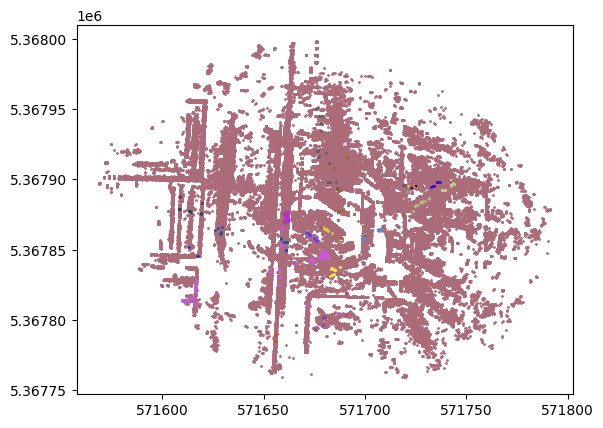

In [82]:
from scipy.spatial import cKDTree

# load ground truth pcd
if params.main.dataset == "scannet":
    pcd_gt = o3d.io.read_point_cloud(
        os.path.join(params.main.scannet_dataset_gt_path, scene_name, f"{scene_name}_vh_clean_2.labels.ply")
    )
elif params.main.dataset == "replica":
    ply_path = os.path.join(params.main.replica_dataset_gt_path, scene_name, "habitat", "mesh_semantic.ply")
    gt_pcd, gt_labels, gt_instance_pcd, gt_instance_id = read_ply_and_assign_colors_replica(
        ply_path, semantic_info_path
    )
    # save the gt pcd using same colors as predicted pcd
    gt_pcd.points = o3d.utility.Vector3dVector(np.asarray(gt_pcd.points))
    # assing colors to gt pcd based on labels
    colors = np.zeros((len(gt_labels), 3))
    for i, label in enumerate(gt_labels):
        colors[i] = colors_map[label]
    gt_pcd.colors = o3d.utility.Vector3dVector(colors)
    # o3d.io.write_point_cloud(os.path.join(save_dir, "gt_pcd.ply"), gt_pcd)

elif params.main.dataset == "truckscenes":
    scene_map_path = f"/shared/data/truckScenes/truckscenes_converted/trainval/{scene_name}/labelled_map.pth"
    xyz, feats, label, inst_label = torch.load(scene_map_path, weights_only=False)
    label = np.array([TRUCKSCENES_LABELS_TO_IDX.get(l, IGNORE_CLASS_INDEX) for l in label], dtype=np.int64)

    # Get corresponding labels for the masks using kdtree
    full_pcd = xyz
    full_pcd_kdtree = cKDTree(full_pcd[:, :3])
    
    # Create a mask for the labels that are not within the masked pcd
    mask = np.zeros(len(full_pcd), dtype=bool)
    
    plt.scatter(
        full_pcd[:, 0],
        full_pcd[:, 1],
        c=np.random.rand(3,),
        s=1,
    )
    
    # print("Min/Max of full_pcd:", np.min(full_pcd, axis=0), np.max(full_pcd, axis=0))
    mask = np.zeros(len(full_pcd), dtype=bool)
    
    masked_pcd_modified = []
    gt_labels = []
    gt_points = []
    
    for pcd_mask in masked_pcd:
        plt.scatter(
            np.array(pcd_mask.points)[:, 0],
            np.array(pcd_mask.points)[:, 1],
            c=np.random.rand(3,),
            s=1,
        )
        # Query neighbors for all masked_pcd points at once
        dists, idxs = full_pcd_kdtree.query(np.asarray(pcd_mask.points), k=1)
        
        # Create a new point cloud with the masked points
        pcd_mask.points = o3d.utility.Vector3dVector(xyz[idxs, :3])
        masked_pcd_modified.append(pcd_mask)
        
        gt_labels.append(label[idxs])
        gt_points.append(xyz[idxs, :3])
        
    gt_labels = np.concatenate(gt_labels, axis=0)
    gt_points = np.concatenate(gt_points, axis=0)


    gt_pcd = o3d.geometry.PointCloud()
    gt_pcd.points = o3d.utility.Vector3dVector(gt_points)
    
    # assing colors to gt pcd based on labels
    colors = np.zeros((len(gt_labels), 3))
    for i, label in enumerate(gt_labels):
        colors[i] = colors_map[label]
    gt_pcd.colors = o3d.utility.Vector3dVector(colors)
    
    
    ## FOR MASK BASED SEGMENTATION ##
    pcd = o3d.geometry.PointCloud()
    for i in range(len(masked_pcd)):
        pcd += masked_pcd_modified[i].paint_uniform_color(colors[i])

    print(np.array(pcd.points).shape, gt_labels.shape)

In [83]:

if params.main.dataset == "scannet":
    # create labels_pred
    label_pre = np.zeros((len(pcd.points), 1))
    for i in range(len(pcd.points)):
        # find the color of the point
        color = np.asarray(pcd.colors[i]) * 255.0
        # find the index of the color in the color map
        color_map_array = np.array(list(SCANNET_COLOR_MAP_20.values()))
        color_diff = np.sum(np.abs(color_map_array - color), axis=1)
        min_diff_index = np.argmin(color_diff)
        # find the label of the point
        label = np.array(list(SCANNET_COLOR_MAP_20.keys()))[min_diff_index]
        label_pre[i] = label
    label_pred = torch.tensor(label_pre)
    # create labels_gt
    labels_gt = np.zeros((len(pcd_gt.points), 1))
    for i in range(len(pcd_gt.points)):
        # find the color of the point
        color = np.asarray(pcd_gt.colors[i]) * 255.0
        # find the index of the color in the color map
        color_map_array = np.array(list(SCANNET_COLOR_MAP_20.values()))
        color_diff = np.sum(np.abs(color_map_array - color), axis=1)
        min_diff_index = np.argmin(color_diff)
        # find the label of the point
        label = np.array(list(SCANNET_COLOR_MAP_20.keys()))[min_diff_index]
        labels_gt[i] = label
    labels_gt = torch.tensor(labels_gt)
    # concat coords and labels for predicied pcd
    coords_labels = np.zeros((len(pcd.points), 4))
    coords_labels[:, :3] = np.asarray(pcd.points)
    coords_labels[:, -1] = label_pred[:, 0]
    coords_gt = np.zeros((len(pcd_gt.points), 4))
    coords_gt[:, :3] = np.asarray(pcd_gt.points)
    coords_gt[:, -1] = labels_gt[:, 0]
    match_pc = knn_interpolation(coords_labels, coords_gt, k=5)
    label_pred = match_pc[:, -1].reshape(-1, 1)
    labels_gt = labels_gt.numpy()

elif params.main.dataset == "replica":
    pred_labels = []
    for i in range(len(masked_pcd)):
        pred_labels.append(np.repeat(labels[i], len(masked_pcd[i].points)))
    pred_labels = np.hstack(pred_labels)

    pred_labels = pred_labels.reshape(-1, 1)
    gt_labels = gt_labels.reshape(-1, 1)

    # concat coords and labels for predicied pcd
    coords_labels = np.zeros((len(pcd.points), 4))
    coords_labels[:, :3] = np.asarray(pcd.points)
    coords_labels[:, -1] = pred_labels[:, 0]
    # concat coords and labels for gt pcd
    coords_gt = np.zeros((len(gt_pcd.points), 4))
    coords_gt[:, :3] = np.asarray(gt_pcd.points)
    coords_gt[:, -1] = gt_labels[:, 0]
    # knn interpolation
    match_pc = knn_interpolation(coords_labels, coords_gt, k=5)
    pred_labels = match_pc[:, -1].reshape(-1, 1)
    ## MATCHING ##
    labels_gt = gt_labels
    label_pred = pred_labels
    assert len(labels_gt) == len(pred_labels)
    
elif params.main.dataset == "truckscenes":
    pred_labels = []
    for i in range(len(masked_pcd_modified)):
        pred_labels.append(np.repeat(labels[i], len(masked_pcd_modified[i].points)))
        
    
    pred_labels = np.hstack(pred_labels)
    pred_labels = pred_labels.reshape(-1, 1)

    gt_labels = gt_labels.reshape(-1, 1)


    print(np.array(pcd.points).shape)
    # concat coords and labels for predicied pcd
    coords_labels = np.zeros((len(pcd.points), 4))
    coords_labels[:, :3] = np.asarray(pcd.points)
    coords_labels[:, -1] = pred_labels[:, 0]
    # concat coords and labels for gt pcd
    coords_gt = np.zeros((len(gt_pcd.points), 4))
    coords_gt[:, :3] = np.asarray(gt_pcd.points)
    coords_gt[:, -1] = gt_labels[:, 0]
    # knn interpolation
    match_pc = knn_interpolation(coords_labels, coords_gt, k=5)
    pred_labels = match_pc[:, -1].reshape(-1, 1)
    ## MATCHING ##
    labels_gt = gt_labels
    label_pred = pred_labels
    assert len(labels_gt) == len(pred_labels)


(518, 3)
knn_classes:  (518, 5)


In [ ]:

# print number of unique labels in the ground truth and predicted pointclouds
print("Number of unique labels in the GT pcd: ", len(np.unique(labels_gt)))
print("Number of unique labels in the pred pcd ", len(np.unique(label_pred)))

# openscene evaluation
if params.main.dataset == "scannet":
    ignore = [0, 1, 7, 8, 20]
elif params.main.dataset == "replica":
    ignore = [-1, 0]
    for id, name in class_id_name.items():
        if (
            "wall" in name
            or "floor" in name
            or "ceiling" in name
            or "door" in name
            or "window" in name
            or "background" in name
        ):
            ignore.append(id)
elif params.main.dataset == "truckscenes":
    ignore = (IGNORE_CLASS_INDEX)

# print(label_pred, labels_gt, ignore)
print("################ {} ################".format(scene_name))
ious = per_class_iou(label_pred, labels_gt, ignore=ignore)
print("per class iou: ", ious)
miou = mean_iou(label_pred, labels_gt, ignore=ignore)
print("miou: ", miou)
fmiou = frequency_weighted_iou(label_pred, labels_gt, ignore=ignore)
print("fmiou: ", fmiou)
macc = mean_accuracy(label_pred, labels_gt, ignore=ignore)
print("macc: ", macc)
pacc = pixel_accuracy(label_pred, labels_gt, ignore=ignore)
print("pacc: ", pacc)
print("#######################################")


Number of unique labels in the GT pcd:  4
Number of unique labels in the pred pcd  4
################ scene-0044384af3d8494e913fb8b14915239e-3 ################


TypeError: argument of type 'float' is not iterable